In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from transformers import AutoModelForVision2Seq, AutoProcessor
from vla.action_tokenizer import RLbenchPoseTokenizer
from vla.base_prompter import PurePromptBuilder
from PIL import Image

/home/lawrence/anaconda3/envs/VLA-RL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = './datasets/pick_described_object/train_data.pt'
# model_path = '/media/lawrence/Work/checkpoints/openvla-7b'

In [3]:
data = torch.load(path)

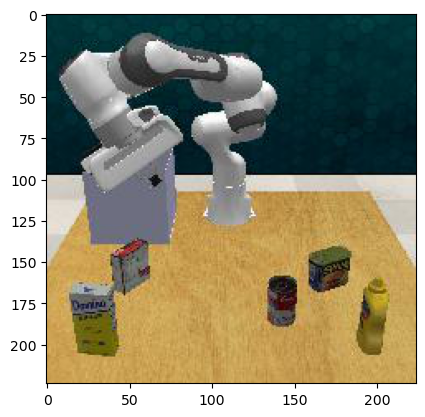

In [40]:
imgs = np.array(data['images'])
shuffled_imgs = imgs[np.random.permutation(len(imgs))]
for img_path in shuffled_imgs:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    break

In [9]:
np.array(data['actions'])[:,-1]

0.5714285714285714

In [4]:
np.mean(data['stages'])

0.5714285714285714

In [34]:
idx = np.where(np.array(data['stages']) == 0)[0]

In [52]:
dt = np.array(data['actions'])
dt0 = dt[np.where(np.array(data['stages']) == 0)[0],:]
dt1 = dt[np.where(np.array(data['stages']) == 1)[0],:]

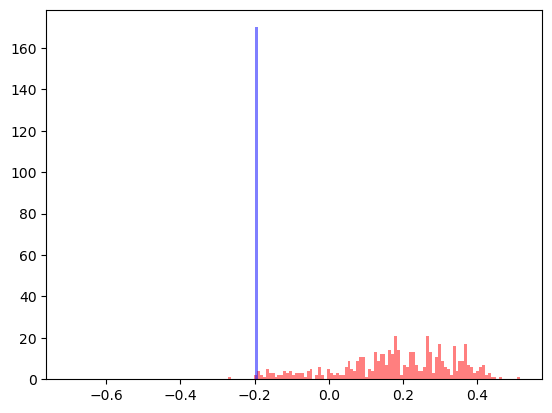

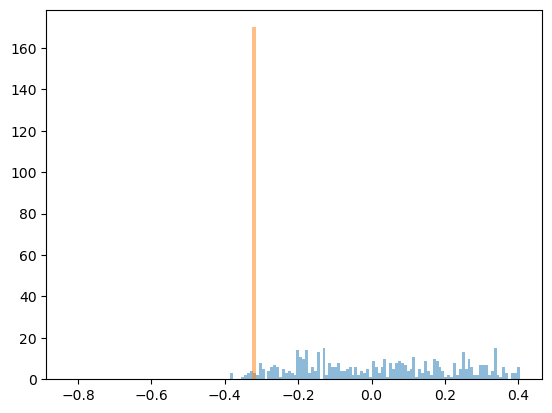

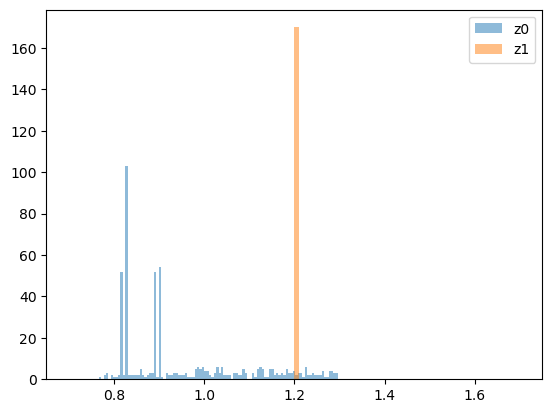

In [56]:
x0 = dt0[:,0]
y0 = dt0[:,1]
z0 = dt0[:,2]
x1 = dt1[:,0]
y1 = dt1[:,1]
z1 = dt1[:,2]
plt.hist(x0, bins=100, alpha=0.5, label='x0', color='r')
plt.hist(x1, bins=100, alpha=0.5, label='x1', color='b')
plt.show()
plt.hist(y0, bins=100, alpha=0.5, label='y0')
plt.hist(y1, bins=100, alpha=0.5, label='y1')
plt.show()
plt.hist(z0, bins=100, alpha=0.5, label='z0')
plt.hist(z1, bins=100, alpha=0.5, label='z1')
plt.legend()

In [77]:
idx[0].shape

(100,)

In [79]:
idx[1][1:][idx[0]>0]

array([3.1515925])

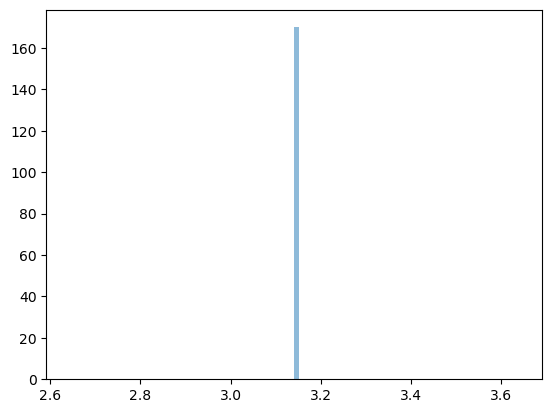

In [68]:
idx = plt.hist(rx1, bins=100, alpha=0.5, label='rx1')

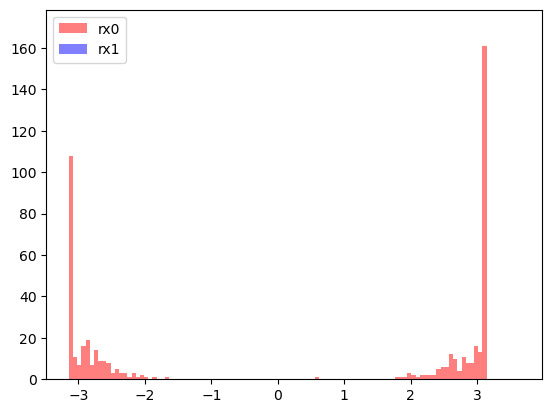

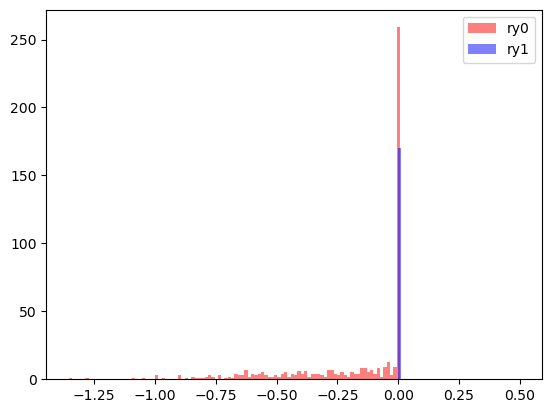

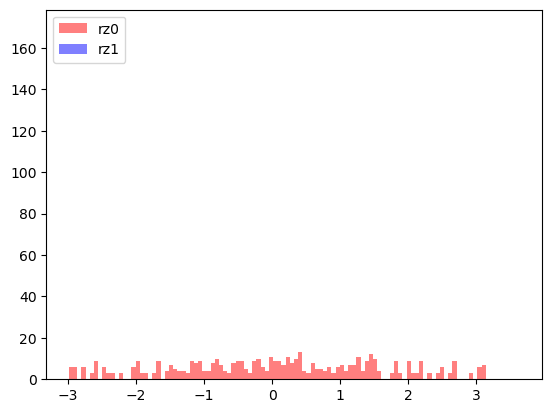

In [84]:
rx0 = dt0[:,3]
ry0 = dt0[:,4]
rz0 = dt0[:,5]
rx1 = dt1[:,3]
ry1 = dt1[:,4]
rz1 = dt1[:,5]
plt.hist(rx0, bins=100, alpha=0.5, label='rx0',color = 'r')
plt.hist(rx1, bins=100, alpha=0.5, label='rx1',color='b')
plt.legend()
plt.show()
plt.hist(ry0, bins=100, alpha=0.5, label='ry0',color='r')
plt.hist(ry1, bins=100, alpha=0.5, label='ry1',color='b')
plt.legend()
plt.show()
plt.hist(rz0, bins=100, alpha=0.5, label='rz0',color='r')
plt.hist(rz1, bins=100, alpha=0.5, label='rz1',color='b')
plt.legend()


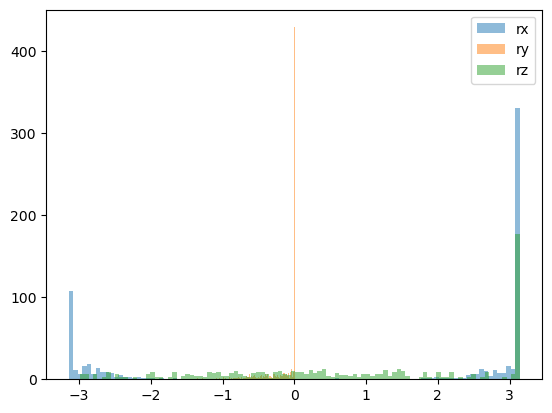

In [50]:
rx = np.stack(data['actions'])[:,3]
ry = np.stack(data['actions'])[:,4]
rz = np.stack(data['actions'])[:,5]
plt.hist(rx, bins=100, alpha=0.5, label='rx')
plt.hist(ry, bins=100, alpha=0.5, label='ry')
plt.hist(rz, bins=100, alpha=0.5, label='rz')
plt.legend()

In [7]:
np.mean(data['stages'])

0.375

In [8]:
rx_ = np.array([rx_ + np.pi if rx_ < 0 else rx_ - np.pi for rx_ in rx])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          1.,   2.,   0.,   1.,   1.,   3.,   0.,   0.,   2.,   2.,   1.,
          0.,   1.,   2.,   1.,   5.,   0.,   5.,   6.,   7.,   2.,   4.,
          4.,   4.,   2.,   5.,   3.,   4.,   3.,   4.,   5.,   1.,   5.,
          7.,   3., 426.,  23.,   4.,   7.,   3.,   4.,   0.,   6.,   2.,
          4.,   7.,   3.,   3.,   2.,   1.,   3.,   3.,   3.,   1.,   4.,
          3.,   2.,   2.,   5.,   1.,   1.,   1.,   1.,   2.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   2.,   2.,   3.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.10173565e+00, -1.07826995e+00, -1.05480425e+00, -1.03133856e+00,
        -1.00787286e+00, -9.84407164e-01, -9.60941467e-01, -9.37475771e-01,
        -9.14010075e-01, -8.90544378e-01, -8.67078682e-01, -8.43612986e-01,
        -8.20147289e-01, -7.96681593e-01, -7.73215897e-01, -7.49750200e-01,
        -7.262

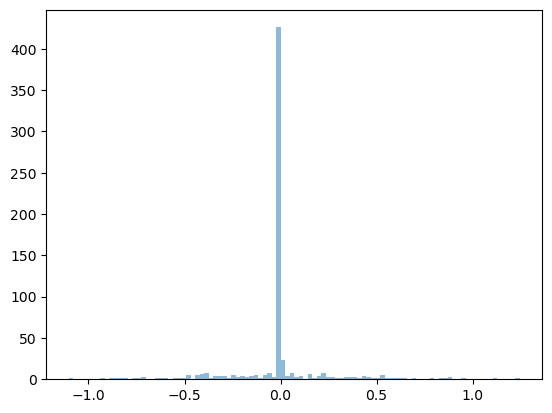

In [9]:
plt.hist(rx_, bins=100, alpha=0.5, label='rx_')

In [40]:
torch.tensor([0])+torch.pi

tensor([3.1416])

In [37]:
np.stack(data['grippers'])[:,-1].mean()

0.35

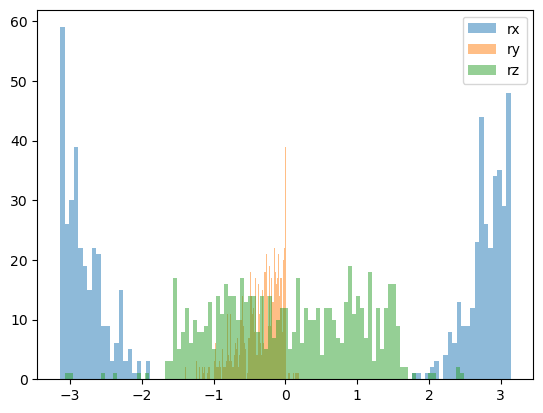

In [10]:
rx = np.stack(data['grippers'])[:,3]
ry = np.stack(data['grippers'])[:,4]
rz = np.stack(data['grippers'])[:,5]
plt.hist(rx, bins=100, alpha=0.5, label='rx')
plt.hist(ry, bins=100, alpha=0.5, label='ry')
plt.hist(rz, bins=100, alpha=0.5, label='rz')
plt.legend()